In [1]:
import pandas as pd
import numpy as np

# Son's Height Prediction

## Introduction

This dataset is taken from [Kaggle](https://www.kaggle.com/abhilash04/fathersandsonheight). The objective of this mini-project is to build a machine learning model to predict the son's height base on his father's height. This is very simple dataset with only 1 feature.

## Load the Data

In [2]:
data = pd.read_csv('dataset/Pearson.txt', sep='\t')

In [3]:
data.head()

,Father,Son
0,65.0,59.8
1,63.3,63.2
2,65.0,63.3
3,65.8,62.8
4,61.1,64.3


## Exploratory Data Analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
data.describe()

,Father,Son
count,1078.000000,1078.000000
mean,67.686827,68.684230
std,2.745827,2.816194
min,59.000000,58.500000
25%,65.800000,66.900000
50%,67.800000,68.600000
75%,69.600000,70.500000
max,75.400000,78.400000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Father  1078 non-null   float64
 1   Son     1078 non-null   float64
dtypes: float64(2)
memory usage: 17.0 KB


The observation shows that:
- All columns are numeric features.
- There is no missing value in any column.

### Correlation

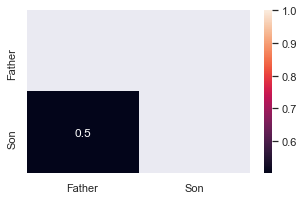

In [7]:
corr = data.corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(5,3))
sns.heatmap(corr, mask=mask, annot=True);

Notice that son's height doesn't have a quite high correlation with his father's height.

### Outliers

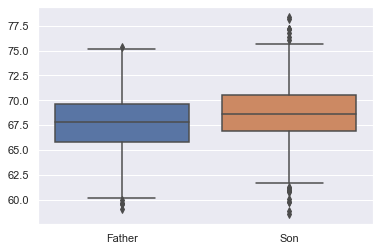

In [8]:
sns.boxplot(data=data);

It seems that the son's height has more variation and has more outliers.

### Additional Infomation

In [9]:
def taller(n):
    if n > 0:
        return 'Father'
    elif n < 0:
        return 'Son'
    else:
        return 'Equal'

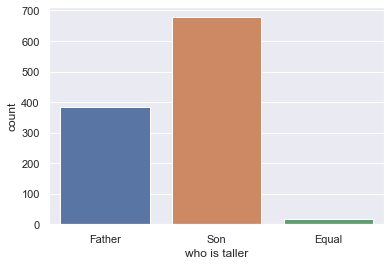

In [10]:
data['who is taller'] = (data['Father'] - data['Son']).apply(taller)
sns.countplot(x='who is taller', data=data);

Notice that more sons have a higher height than their fathers. I think this information could be useful for making the prediction. As said, I decide to make this information as a column.

## Modeling

In [11]:
# Regressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Model Selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Scoring
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

There is a close relationship between father's and son's height. I consider to test the following model and see which one performs the best:
- **LinearRegression**
 - This is the simplest linear model.
 - Father's and son's height could have a linear relationship.
- **DecisionTreeRegressor**
 - This problem may consider as a decision as there is a new feature telling "who is taller".
- **RandomForestRegressor**
 - This is a DecisionTree-based ensemble model, so it should perform better.
- **KNeighborsRegressor**
 - The prediction may be close to other samples that have similar conditions.
- **XGBRegressor**
 - This is also a DecisionTree-based ensemble model that uses a gradient boosting algorithm.
 - It should perform better than RandomForest algorithm.

### Train Test Split

In [12]:
X = data.drop('Son', axis=1)
y = data['Son']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Model Selection

In [13]:
features = Pipeline([
    ('encode', ColumnTransformer([
        ('taller', OneHotEncoder(), ['who is taller'])
    ], remainder='passthrough'))
])

In [14]:
estimators = {
    'LR': LinearRegression(),
    'DT': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'XGB': XGBRegressor()
}

for name, estimator in estimators.items():
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = cross_val_score(estimator, features.fit_transform(X), y, cv=cv, n_jobs=-1)
    print('{}: {:.3f}'.format(name, scores.mean()))

LR: 0.640
DT: 0.525
RF: 0.555
KNN: 0.554
XGB: 0.620


The observation shows that LinearRegression performs the best, followed by XGBRegressor. I decide to dive deeper into these models by tuning their hyperparameters. But notice that there is no hyperparameter to tune in LinearRegression, so I only tune the hyperparameters of XGBRegressor.

### Fit the Model

#### 1. LinearRegression

In [15]:
est_v1 = Pipeline([
    ('features', features),
    ('regressor', LinearRegression())
])
est_v1.fit(X_train, y_train);

#### 2. XBGRegressor

In [16]:
params = {
    'learning_rate': np.arange(0.1, 0.3, 0.1),
    'max_depth': np.arange(2, 11, 2),
    'min_child_weight': np.arange(2, 11, 2),
    'gamma': np.arange(0.1, 0.3, 0.1),
    'colsample_bytree': np.arange(0.1, 0.3, 0.1)
}

est_v2 = Pipeline([
    ('features', features),
    ('regressor', GridSearchCV(XGBRegressor(), param_grid=params, cv=5, n_jobs=-1, verbose=1))
])
est_v2.fit(X_train, y_train);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   31.7s


[12:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   35.9s finished


### Scoring

In [17]:
pd.DataFrame({'LR': est_v1.predict(X_test),
              'XGB': est_v2.predict(X_test),
              'True': y_test}).sample(5)

,LR,XGB,True
1019,70.971739,70.602409,70.2
480,67.673286,67.822418,67.2
860,64.217765,64.416206,61.7
311,67.045010,67.417191,68.6
180,70.236910,70.337631,72.3


In [18]:
columns = [('R2', ''), ('Train', 'MAE'), ('Train', 'MSE'), ('Test', 'MAE'), ('Test', 'MSE')]

scoring = pd.DataFrame({'R2': [est_v1.score(X_test, y_test),
                               est_v2.score(X_test, y_test)],
                        
                        'MAE': [mean_absolute_error(y_train, est_v1.predict(X_train)),
                                mean_absolute_error(y_train, est_v2.predict(X_train))],
                        
                        'MSE': [mean_squared_error(y_train, est_v1.predict(X_train)),
                                mean_squared_error(y_train, est_v2.predict(X_train))],
                        
                        'MAE_': [mean_absolute_error(y_test, est_v1.predict(X_test)),
                                 mean_absolute_error(y_test, est_v2.predict(X_test))],
                        
                        'MSE_': [mean_squared_error(y_test, est_v1.predict(X_test)),
                                 mean_squared_error(y_test, est_v2.predict(X_test))]
                       }, index=['LR', 'XGB'])

scoring.columns = pd.MultiIndex.from_tuples(columns)
scoring

R2     Train                Test          
                    MAE       MSE       MAE       MSE
LR   0.639411  1.295293  2.753375  1.339950  2.975413
XGB  0.632868  1.260393  2.660522  1.322057  3.029409

Notice that LinearRegression and XGBRegressor are giving almost the same results. But I would prefer to go with **LinearRegression** as it is a much simpler model and faster to train.